In [1]:
import pandas as pd
import numpy as np
import json
# Load the JSON file (replace with correct path)
with open('user-wallet-transactions.json') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)
df.head()


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [2]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Check number of unique users
print("Unique wallets:", df['userWallet'].nunique())

# Check available actions
print("Unique actions:", df['action'].value_counts())


Unique wallets: 3497
Unique actions: action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64


In [3]:
# Overview
print(df.info())
print(df['action'].value_counts())
print(df['userWallet'].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   _id          100000 non-null  object        
 1   userWallet   100000 non-null  object        
 2   network      100000 non-null  object        
 3   protocol     100000 non-null  object        
 4   txHash       100000 non-null  object        
 5   logId        100000 non-null  object        
 6   timestamp    100000 non-null  datetime64[ns]
 7   blockNumber  100000 non-null  int64         
 8   action       100000 non-null  object        
 9   actionData   100000 non-null  object        
 10  __v          100000 non-null  int64         
 11  createdAt    100000 non-null  object        
 12  updatedAt    100000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 9.9+ MB
None
action
deposit             37808
redeemunderlying    32305
borrow

In [4]:
# Extract numeric values from actionData (if present)
def extract_amount(data):
    try:
        return float(data.get('amount', 0))
    except:
        return 0.0

df['amount'] = df['actionData'].apply(lambda x: extract_amount(x) if isinstance(x, dict) else 0)

In [5]:


# Transaction counts per action per user
action_counts = df.pivot_table(index='userWallet', columns='action', aggfunc='size', fill_value=0)

# Aggregate amount stats
amount_agg = df.groupby('userWallet')['amount'].agg(['sum', 'mean', 'max']).rename(
    columns={'sum': 'amount_sum', 'mean': 'amount_mean', 'max': 'amount_max'})

# Total transactions
df['transaction_count'] = 1
txn_count = df.groupby('userWallet')['transaction_count'].count()

# Combine all features
features = pd.concat([action_counts, amount_agg, txn_count], axis=1)
features = features.fillna(0)
features.reset_index(inplace=True)


In [6]:
# Create proxy score using heuristics (can be replaced with true labels if provided)
features['borrow_deposit_ratio'] = features.get('borrow', 0) / (features.get('deposit', 1))
features['simulated_score'] = (
    600 
    + 0.2 * features['amount_mean'] 
    - 100 * features['borrow_deposit_ratio']
    - 0.1 * features.get('liquidationcall', 0)
).clip(0, 1000)
print(features['simulated_score'].isna().sum())  # Should be 0
features = features.dropna(subset=['simulated_score'])

144


In [7]:
X = features.drop(columns=['userWallet', 'simulated_score'])
y = features['simulated_score']

In [8]:
# Check for inf, NaN, or large values
print("Any NaN in X:", X.isna().sum().sum())
print("Any Inf in X:", np.isinf(X).sum().sum())
print("Max value in X:", X.max().max())
print("Min value in X:", X.min().min())


Any NaN in X: 0
Any Inf in X: 25
Max value in X: inf
Min value in X: 0.0


In [9]:
# Replace inf with 0
X.replace([np.inf, -np.inf], 0, inplace=True)

# Replace NaN with 0
X.fillna(0, inplace=True)

# Also ensure y has no NaNs
y = y.fillna(0)


In [10]:
from sklearn.model_selection import train_test_split
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model R² Score on Test Set:", model.score(X_test, y_test))


Model R² Score on Test Set: 0.999987785331069


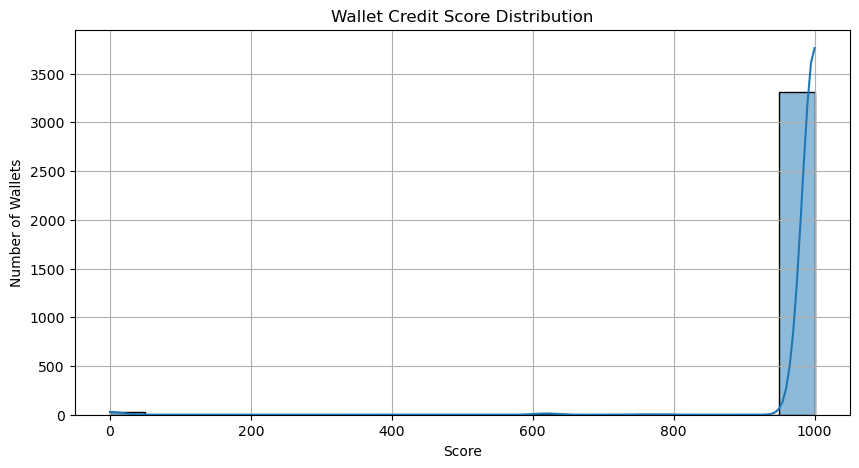

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
features['predicted_score'] = model.predict(X)

# Score distribution plot
plt.figure(figsize=(10,5))
sns.histplot(features['predicted_score'], bins=20, kde=True)
plt.title('Wallet Credit Score Distribution')
plt.xlabel('Score')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()


In [12]:
# Save results for README / analysis.md
features[['userWallet', 'predicted_score']].to_csv("wallet_scores.csv", index=False)


In [13]:
features

,userWallet,borrow,deposit,liquidationcall,redeemunderlying,repay,amount_sum,amount_mean,amount_max,transaction_count,borrow_deposit_ratio,simulated_score,predicted_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,0,1,0,0,0,2.000000e+09,2.000000e+09,2.000000e+09,1,0.000000,1000.0,1000.000
1,0x000000000051d07a4fb3bd10121a343d85818da6,0,1,0,0,0,1.450000e+20,1.450000e+20,1.450000e+20,1,0.000000,1000.0,1000.000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,0,2,0,0,0,5.000000e+15,2.500000e+15,4.000000e+15,2,0.000000,1000.0,1000.000
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,15,250,0,130,4,1.735192e+23,4.348853e+20,1.600000e+22,399,0.060000,1000.0,1000.000
5,0x000000000a38444e0a6e37d3b630d7e855a7cb13,8,7,0,5,5,1.061192e+22,4.244767e+20,6.640000e+21,25,1.142857,1000.0,1000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,0,1,0,0,0,9.800000e+01,9.800000e+01,9.800000e+01,1,0.000000,619.6,619.598
3493,0x06189341e523a52ae10c4bd4a7774371fac1b249,1,4,0,2,0,1.697882e+19,2.425546e+18,6.064412e+18,7,0.250000,1000.0,1000.000
3494,0x0618c450370822c5cb25ec143a3008230d8e2c12,0,1,0,4,0,7.101535e+21,1.420307e+21,7.073324e+21,5,0.000000,1000.0,1000.000
3495,0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2,2,13,0,5,2,2.516332e+21,1.143787e+20,5.000000e+20,22,0.153846,1000.0,1000.000
